# Data Processing, Wrangling and EDA

---
### Required Libs

In [68]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import io
import talib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from IPython.display import Image
from talib.abstract import *
# import pandas_ta as talib

In [200]:
# Creating path to save Plotly image files:
if not os.path.exists("images"):
    os.mkdir("images")

figindex = 0 # figure dynamic index

# Function to display images:
def figshow(figindex, fig):
    fig.write_image(f"images/fig{figindex}.png")
    return Image(f"images/fig{figindex}.png")

In [201]:
# Yang & Zhang volatility 
# implementation from tangabc: https://gist.github.com/tangabc/d9700366bd75ce49b1f4ea7a1a1030bf
def get_hvol_yz(df, lookback=10):
    o = df.Open
    h = df.High
    l = df.Low
    c = df.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

#Defining class weights (to deal with class imbalance):
def cwts(df):
    c0, c1 = np.bincount(df['target'])
    #making the weights inversely proportional to the amount of observations:
    w0, w1 = (1/c0)*(len(df))/2, (1/c1)*(len(df))/2
    return {0: w0, 1:w1}

---
## Datasets used

* [Ethereum data](https://www.kaggle.com/datasets/varpit94/ethereum-data?resource=download)

* [Bitcoin data](https://www.kaggle.com/datasets/varpit94/ethereum-data?resource=download)


---
### Data Processing

In [202]:
eth = pd.read_csv("datasets\ETH-USD.csv")
btc = pd.read_csv("datasets\BTC-USD.csv")

In [203]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1598 non-null   object 
 1   Open       1598 non-null   float64
 2   High       1598 non-null   float64
 3   Low        1598 non-null   float64
 4   Close      1598 non-null   float64
 5   Adj Close  1598 non-null   float64
 6   Volume     1598 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.5+ KB


In [204]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [205]:
# Checking NaNs
eth.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [206]:
# Checking NaNs
btc.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We restrict both to the same time period to explore their correlation as a feature.

In [207]:
start = max(btc.Date.min(), eth.Date.min())
end = min(btc.Date.max(), eth.Date.max())

print(f"The datasets are restricted as such: \n Initial date: {start} \n End date: {end} ")

eth.query("@start<=Date<=@end", inplace = True)
btc.query("@start<=Date<=@end", inplace = True)

print(f"Which leaves us with: {eth.shape[0]} days obs for ETH and {btc.shape[0]} days obs for BTC")

The datasets are restricted as such: 
 Initial date: 2017-11-09 
 End date: 2022-03-25 
Which leaves us with: 1598 days obs for ETH and 1598 days obs for BTC


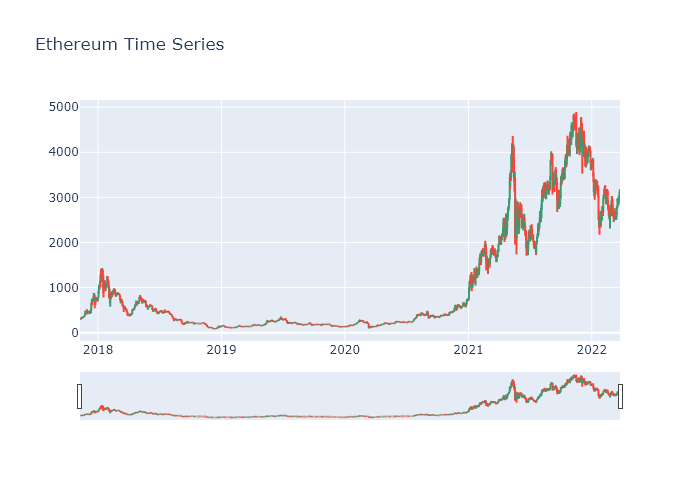

In [208]:
# Plotting OHLC for both datasets

fig = go.Figure(data=go.Ohlc(x=eth['Date'],
                    open=eth['Open'],
                    high=eth['High'],
                    low=eth['Low'],
                    close=eth['Close']))

fig.update_layout(title="Ethereum Time Series")
figindex += 1
figshow(figindex,fig)

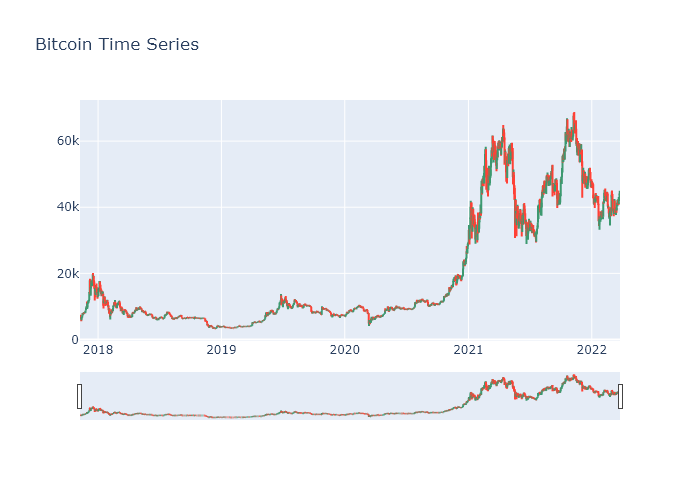

In [209]:
# Plotting OHLC for both datasets

fig = go.Figure(data=go.Ohlc(x=btc['Date'],
                    open=btc['Open'],
                    high=btc['High'],
                    low=btc['Low'],
                    close=btc['Close']))

fig.update_layout(title="Bitcoin Time Series")
figindex += 1
figshow(figindex,fig)

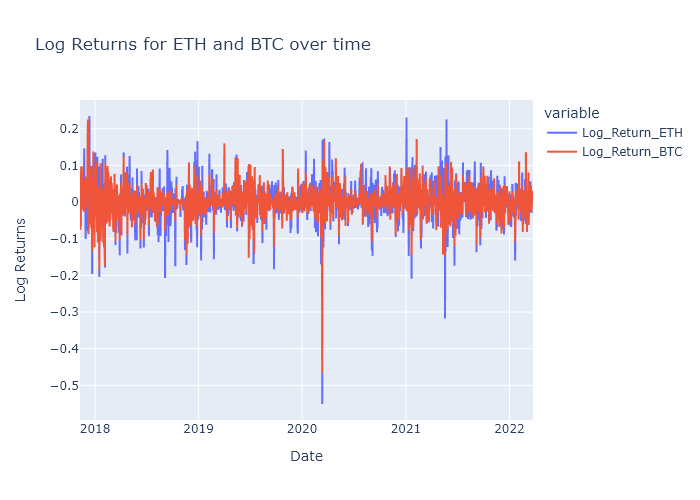

In [210]:
# Checking their Log_Returns:
eth['Pct_chg'], btc['Pct_chg'] = (eth['Close']/eth['Close'].shift(1))-1,  btc['Close']/btc['Close'].shift(1)-1
eth['Log_Return'], btc['Log_Return'] = np.log(eth['Close']) - np.log(eth['Close'].shift(1)),  np.log(btc['Close']) - np.log(btc['Close'].shift(1))

# Plotting one against the other:
both = eth[['Date','Log_Return']].merge(btc[['Date','Log_Return']], on='Date', suffixes= ['_ETH','_BTC']).set_index('Date')

fig = px.line(both, title = "Log Returns for ETH and BTC over time")
fig.update_layout(yaxis_title="Log Returns")
figindex += 1
figshow(figindex,fig)

It appears that both follow each others movements. 

Plotting their log returns against each other yields:

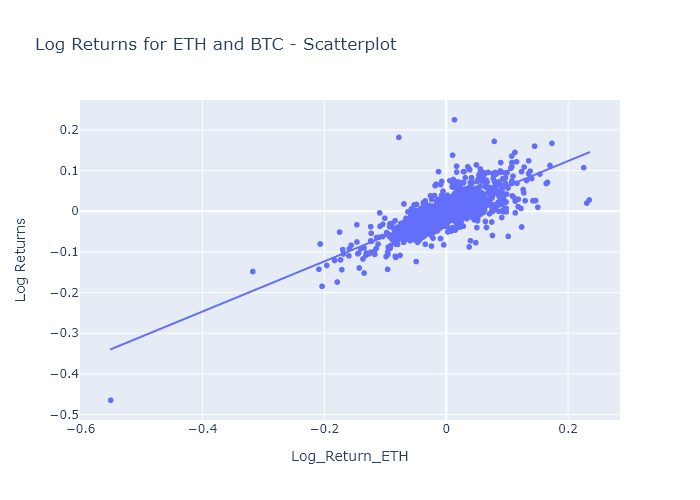

In [211]:
fig = px.scatter(both, x='Log_Return_ETH', y= 'Log_Return_BTC', title = "Log Returns for ETH and BTC - Scatterplot", trendline='ols')

fig.update_layout(yaxis_title="Log Returns")
figindex += 1
figshow(figindex,fig)

In [212]:
both.corr()

,Log_Return_ETH,Log_Return_BTC
Log_Return_ETH,1.000000,0.776484
Log_Return_BTC,0.776484,1.000000


Per the OLS regression line, the returns seem to be correlated. The correlation matrix reiterates BTC  & ETH high, positive correlation.

---
### Feature Engineering

Using pandas-TA built-in convenience, we create many different technical indicators at once.

In [213]:
# lookbacks = [5,10,21,50]

# Defining inputs:
inputs = {
    'open': eth['Open'],
    'high':eth['High'],
    'low': eth['Low'],
    'close':eth['Close'],
    'volume':eth['Volume'],
}


Creating Technical indicators

In [214]:
# For Ethereum:
for func in ['EMA', 'ATR', 'STOCH', 'MACD', 'CCI', 'AD', 'BBANDS', 'MOM']:
    for l in lookbacks:
        col_name = f'{func}_{l}'
        
        try: #will only vary timeperiods if time period is present as a parameter
            eth[col_name] = eval(f'{func}(inputs, timeperiod={l})')
            
        except: #when time window is not present as a parameter & or there is more than 1 output
            # print(col_name)
            if func == "STOCH":    
                eth[col_name+'_slowk'],eth[col_name+'_slowd'] = eval(f'{func}(inputs)')
            elif func =="MACD":
                eth[col_name], eth[col_name+ '_signal'], eth[col_name+ '_hist'] = eval(f'{func}(inputs)')
            elif func =="BBANDS":
                eth[col_name+'_upperband'], eth[col_name+ '_middleband'], eth[col_name+ '_lowerband '] = eval(f'{func}(inputs, timeperiod={l})')
            else:
                print(col_name+' deu ruim')
                pass

# Adding drift-independent volatility (Yang & Zhang)

for l in lookbacks:
    eth[f'di_vol_{l}'] = get_hvol_yz(eth,lookback=l)

In [215]:
# We also backfill columns to avoid NaNs
eth = eth.bfill(axis=1)

We then define the target variable as the pct_change direction:

In [216]:
eth['target'] = np.where(eth['Pct_chg']>0, 1, 0)

In [217]:
classes = eth['target'].value_counts()
classes

1    834
0    764
Name: target, dtype: int64

As we have class imbalance, we assign appropriate weights (inversely proportional to the number of observations):

In [218]:
class_weights = cwts(eth)
class_weights

{0: 1.0458115183246075, 1: 0.9580335731414867}

Which yields equal weight per class:

In [219]:
round(class_weights[0] * classes[0]), round(class_weights[1] * classes[1])

(799, 799)

In [220]:
# Dropping unnecessary columns
df = eth.drop(['Open','High','Low', 'Close','Adj Close','Volume','Pct_chg','Log_Return'], axis=1)
print(df.shape)
df.head()

(1598, 58)


,Date,EMA_5,EMA_10,EMA_21,EMA_50,ATR_5,ATR_10,ATR_21,ATR_50,STOCH_5_slowk,...,BBANDS_50_lowerband,MOM_5,MOM_10,MOM_21,MOM_50,di_vol_5,di_vol_10,di_vol_21,di_vol_50,target
0,2017-11-09,209792136.430988,209792136.430988,209792136.430988,209792136.430988,209792136.430988,209792136.430988,209792136.430988,209792136.430988,209792136.430988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2017-11-10,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,-399558125.390636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2017-11-11,64636507.847033,64636507.847033,64636507.847033,64636507.847033,64636507.847033,64636507.847033,64636507.847033,64636507.847033,64636507.847033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2017-11-12,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,-79985206.497542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2017-11-13,311.888397,70.924691,70.924691,70.924691,70.924691,70.924691,70.924691,70.924691,70.924691,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
